In [66]:
import ipyparallel as ipp

In [67]:
cluster = ipp.Cluster(engines="mpi", n=5)

In [68]:
rc = cluster.start_and_connect_sync()

Starting 5 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/5 [00:00<?, ?engine/s]

In [69]:
dv = rc[:]

In [70]:
%%px --local
%load_ext autoreload
%autoreload 2

In [71]:
%%px --local
from pathlib import Path

import cv2
import fast.s26_analysis.utils as utils
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import odl
import skimage
import tifffile as tif
from fast.utils.generate_scan_pattern import generate_scan_pattern as gcn
from fast.utils.img_loader import renormalize
from tqdm.notebook import tqdm

In [72]:
%%px --local
frbh = lambda x, m: skimage.restoration.inpaint_biharmonic(x * m, (1 - m).astype("bool"))
frns = lambda x, m: cv2.inpaint(x * m, 1 - m, 10, cv2.INPAINT_NS)

In [73]:
%%px --local
shape = np.array([128, 128])

In [74]:
space = odl.uniform_discr([-1, -1], [1, 1], shape)

In [75]:
shepp_logan = odl.phantom.transmission.shepp_logan(space, modified=True)

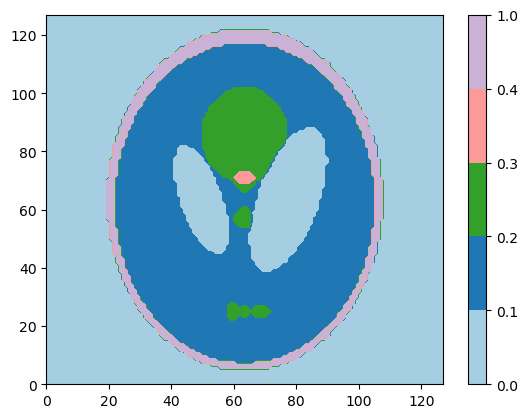

In [76]:
# plt.imshow(shepp_logan.asarray().T[::-1])
plt.contourf(shepp_logan.asarray()[::-1].T, [0, 0.1, 0.2, 0.3, 0.4, 1.0], cmap="Paired")
plt.colorbar()

In [77]:
np.unique(shepp_logan.asarray()[shepp_logan.asarray() > 0])

array([ 0.1,  0.2,  0.3,  0.4,  1. ])

In [78]:
(shepp_logan.asarray() == 0.1).sum()

24

In [79]:
noise = odl.phantom.noise.white_noise(space, stddev=0.005)

In [80]:
sp_noise = shepp_logan + noise

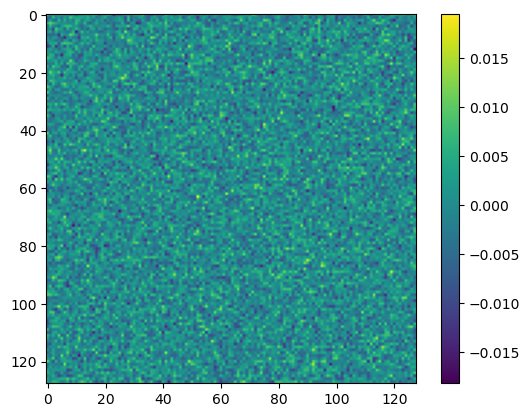

In [81]:
plt.imshow(noise)
plt.colorbar()

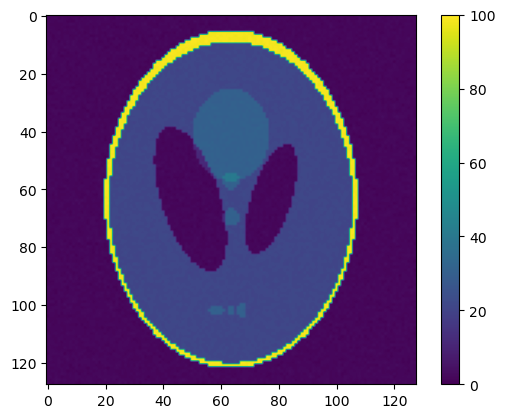

In [82]:
plt.imshow(renormalize(sp_noise.asarray())[:, ::-1].T)
plt.colorbar()

[  10.   20.   30.   40.  100.]
[  10.   20.   30.   40.  100.]
[  10.   20.   30.  100.]
[  20.   30.  100.]
[  20.   30.  100.]


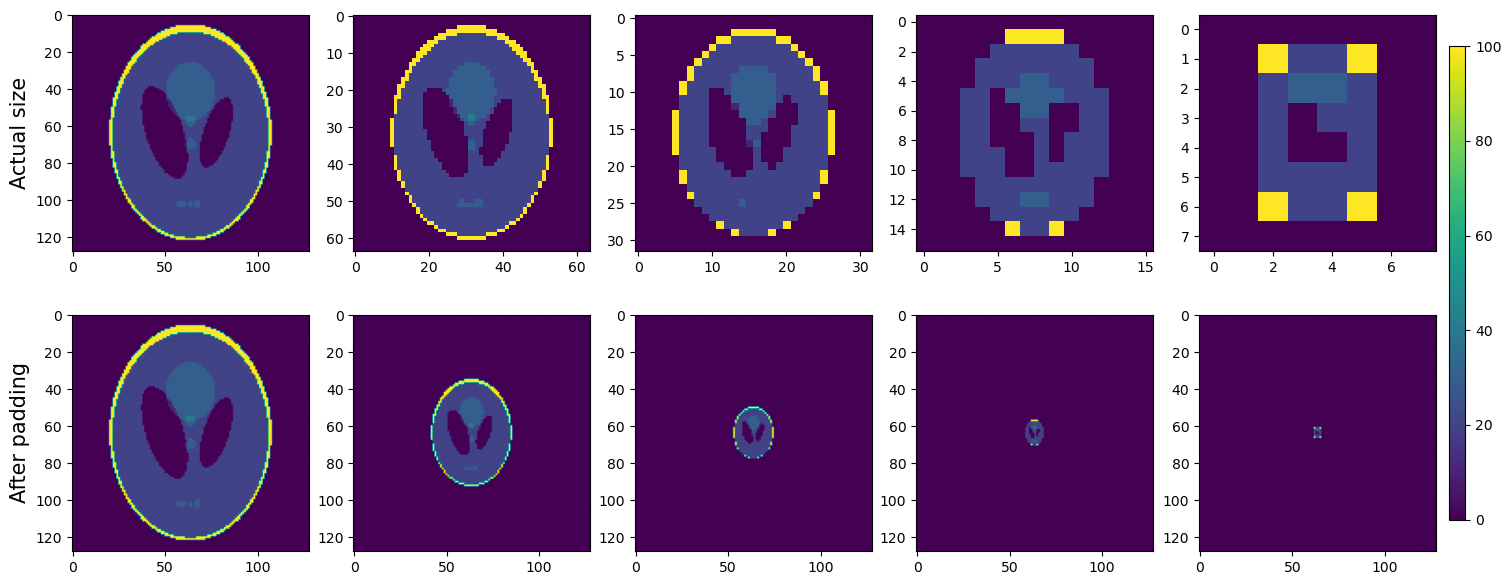

In [83]:
sps_scaled = {}
shapes_scaled = {}

fig, axs = plt.subplots(2, 5, figsize=[15, 6], constrained_layout=True)

for i in range(5):
    shape_this = shape // 2**i
    space_this = odl.uniform_discr([-1, -1], [1, 1], shape=shape // 2**i)
    sp_orig = renormalize(odl.phantom.shepp_logan(space_this, modified=True).asarray().T[::-1])

    sp_nonzero = sp_orig[sp_orig > 0]
    print(np.unique(sp_nonzero))

    sp_this = np.pad(sp_orig, [64 - shape_this // 2, 64 - shape_this // 2])
    noise_this = odl.phantom.noise.white_noise(space, stddev=0.5).asarray()
    sp_this += noise_this

    cim = axs[0, i].imshow(sp_orig, vmin=0, vmax=100)
    # plt.gca().clabel(cs, cs.levels, inline=True,  fontsize=10)
    # plt.gca().invert_yaxis()
    axs[1, i].imshow(sp_this, vmin=0, vmax=100)

    sps_scaled[i] = renormalize(sp_this)
    shapes_scaled[i] = shape_this
axs[0, 0].set_ylabel("Actual size", fontsize=15)
axs[1, 0].set_ylabel("After padding", fontsize=15)
fig.colorbar(ax=axs, mappable=cim, pad=0.01, shrink=0.8, use_gridspec=True, aspect=30)
plt.show()

In [106]:
%%px --local
# Get a 1% measurement mask
init_pattern = gcn(*shape, 0.01, verbose=False)

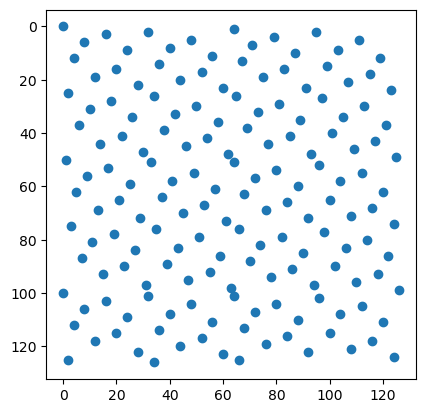

In [107]:
plt.scatter(*init_pattern.T)
plt.gca().invert_yaxis()
plt.gca().set_aspect("equal")

In [108]:
dv.scatter("sps_c", sps_scaled.items())
dv.scatter("shapes_scaled", shapes_scaled.items())

<AsyncResult(scatter): pending>

In [109]:
%%px
shapes_scaled = dict(shapes_scaled)

In [110]:
%%px
masks_all = {}
recons_fast_all = {}
ratios_all = {}
tot_erds_all = {}
samples_all = {}
for _n, sp in sps_c:
    sample_this = utils.create_experiment_sample(
        numx=shape[1], numy=shape[0], inner_batch_size=50, initial_idxs=init_pattern
    )
    masks_this = []
    recons_fast_this = []
    ratios_this = []
    tot_erds_this = []

    count = 0
    new_idxs = init_pattern

    n_scan_points = int(0.5 * sp.size)
    pbar = tqdm(total=n_scan_points, desc="Scanned points")
    # Continue until we measure 40% of the points.
    while sample_this.mask.sum() < n_scan_points:
        # Supply the measurement values.
        sample_this.measurement_interface.finalize_external_measurement(sp[new_idxs[:, 0], new_idxs[:, 1]])

        # Supply in measurement positions
        sample_this.perform_measurements(new_idxs)

        # Use the measurement values to reconstruct the sample and calculate the ERDs
        sample_this.reconstruct_and_compute_erd()

        # Compute new positions.
        new_idxs = sample_this.find_new_measurement_idxs()[:50]

        ratio = sample_this.ratio_measured
        ratios_this.append(ratio)
        tot_erds_this.append(sample_this.ERD.sum())
        recons_fast_this.append(sample_this.recon_image.copy())
        masks_this.append(sample_this.mask.copy())
        pbar.update(int(sample_this.mask.sum() - pbar.n))

    masks_all[_n] = masks_this
    recons_fast_all[_n] = recons_fast_this
    ratios_all[_n] = ratios_this
    tot_erds_all[_n] = tot_erds_this
    samples_all[_n] = sample_this

[output:2]

Scanned points:   0%|          | 0/8192 [00:00<?, ?it/s]

[output:0]

Scanned points:   0%|          | 0/8192 [00:00<?, ?it/s]

[output:1]

Scanned points:   0%|          | 0/8192 [00:00<?, ?it/s]

[output:3]

Scanned points:   0%|          | 0/8192 [00:00<?, ?it/s]

[output:4]

Scanned points:   0%|          | 0/8192 [00:00<?, ?it/s]

%px:   0%|          | 0/5 [00:00<?, ?tasks/s]

In [111]:
%%px --target 1
np.shape(recons_fast_all[1])

Out[1:13]: (162, 128, 128)

In [112]:
%%px --local
inpainting = True

In [113]:
%%px --local
center = shape // 2

In [114]:
%%px
data_all = {}
skip = 2
for n1, sp_this in sps_c:
    shape_this = shapes_scaled[n1]
    label = n1
    _recons = []
    _masks = []
    _recons_bh = []
    _psnrs = []
    _ssims = []
    _rmses = []
    _ratios = []
    ratios_this = ratios_all[n1]

    for n2, scan_ratio in tqdm(enumerate(ratios_this)):
        if n2 % skip != 0:
            continue
        r1 = recons_fast_all[n1][n2]
        m1 = masks_all[n1][n2].astype("bool")

        actual_max = sp_this[m1][np.argmax(r1[m1])]
        actual_min = sp_this[m1][np.argmin(r1[m1])]

        r2 = renormalize(r1, max_value=255, min_value=0).astype(
            "float32"
        )  # actual_max, min_value=actual_min).astype('float32')

        if inpainting:
            r2 = frbh(r2, m1)
            # _r2 = recons_scipy(_r2, _m1, kernel='inverse_quadratic')
            # r2 = frns(r2, m1.astype('uint8'))
            r2[r2 > 255] = 255
            r2[r2 < 0] = 0
        r2 = renormalize(r2, max_value=actual_max, min_value=actual_min)

        roi = [np.maximum(center[0] - shape_this[0] - 2, 0), np.minimum(center[0] + shape_this[0] + 2, shape[0])]

        sp_roi = sp_this[roi[0] : roi[1], roi[0] : roi[1]]
        r2_roi = r2[roi[0] : roi[1], roi[0] : roi[1]]
        _ssims.append(skimage.metrics.structural_similarity(sp_roi, r2_roi, data_range=100))
        _psnrs.append(skimage.metrics.peak_signal_noise_ratio(sp_roi, r2_roi, data_range=100))
        _rmses.append(skimage.metrics.normalized_root_mse(sp_roi, r2_roi))

        _recons.append(r1)
        _masks.append(m1)
        _recons_bh.append(r2)
        _ratios.append(scan_ratio)

    data_all[label] = {
        "recons": _recons,
        "masks": _masks,
        "recons_bh": _recons_bh,
        "ssims": _ssims,
        "psnrs": _psnrs,
        "rmses": _rmses,
        "scan_ratios": _ratios,
    }
    for d, v in data_all[label].items():
        data_all[label][d] = np.array(v)

[output:0]

0it [00:00, ?it/s]

[output:4]

0it [00:00, ?it/s]

[output:2]

0it [00:00, ?it/s]

[output:1]

0it [00:00, ?it/s]

[output:3]

0it [00:00, ?it/s]

%px:   0%|          | 0/5 [00:00<?, ?tasks/s]

In [115]:
data_per_label = {}

for client in dv.client:
    data_all_dict = client["data_all"]
    data_per_label.update(data_all_dict)

In [116]:
save_dir = Path("features_sizes")
save_dir.mkdir(exist_ok=True)
save_fname = save_dir / "data_all.joblib"

In [117]:
joblib.dump(data_per_label, save_fname, compress=5)

['features_sizes/data_all.joblib']

In [118]:
!du -hc

88M	./features_sizes
30M	./.ipynb_checkpoints
57M	./features_densities
15M	./features_sizes_forbild
219M	.
219M	total


In [119]:
from cycler import cycler

In [120]:
markers = cycler(marker=[".", "o", "D", "<", "s", "P", "X", "D", 9, 10, "d"])
linestyle_tuple = ls = [
    ("loosely dotted", (0, (1, 10))),
    ("dotted", (0, (1, 1))),
    ("densely dotted", (0, (1, 1))),
    ("densely dashdotdotted", (0, (3, 1, 1, 1, 1, 1))),
    ("dashdotdotted", (0, (3, 5, 1, 5, 1, 5))),
    ("dashed", (0, (5, 5))),
    ("densely dashed", (0, (5, 1))),
    ("dashdotted", (0, (3, 5, 1, 5))),
    ("densely dashdotted", (0, (3, 1, 1, 1))),
    ("loosely dashdotdotted", (0, (3, 10, 1, 10, 1, 10))),
    ("densely dashdotdotted", (0, (3, 1, 1, 1, 1, 1))),
]
ls_cycler = [l[1] for l in linestyle_tuple]
prop_cycler = markers + cycler(ls=ls_cycler)

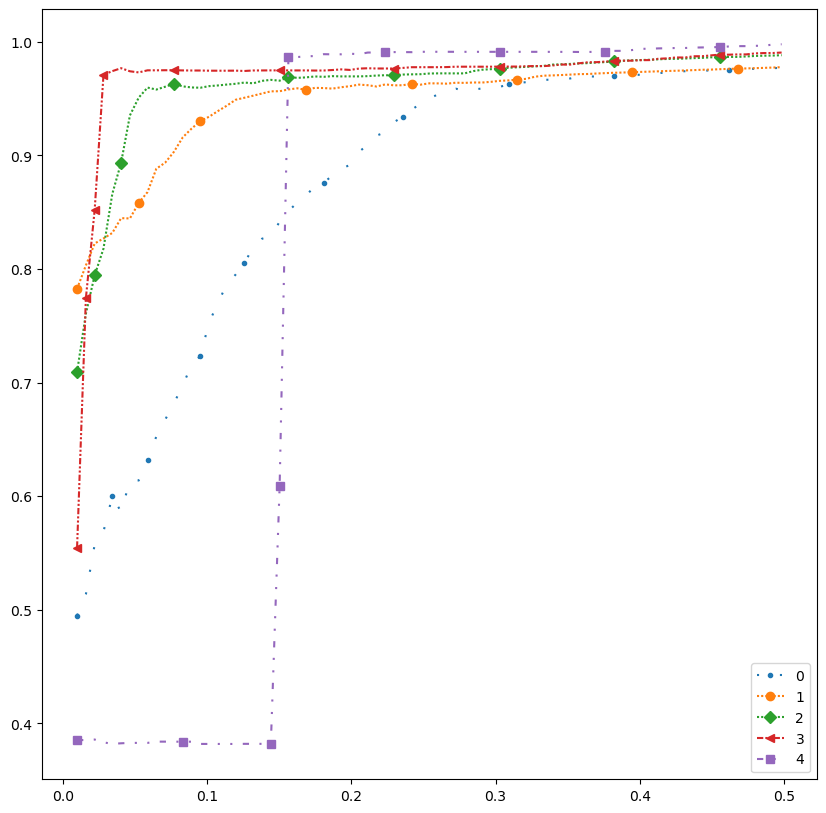

In [121]:
pc = prop_cycler()
plt.figure(figsize=[10, 10])
for ix, label in enumerate(data_per_label):
    plt.plot(
        data_per_label[label]["scan_ratios"], data_per_label[label]["ssims"], label=label, markevery=0.1, **next(pc)
    )
plt.legend(loc="best")

# plt.xlim([0.01, 0.3])
plt.show()

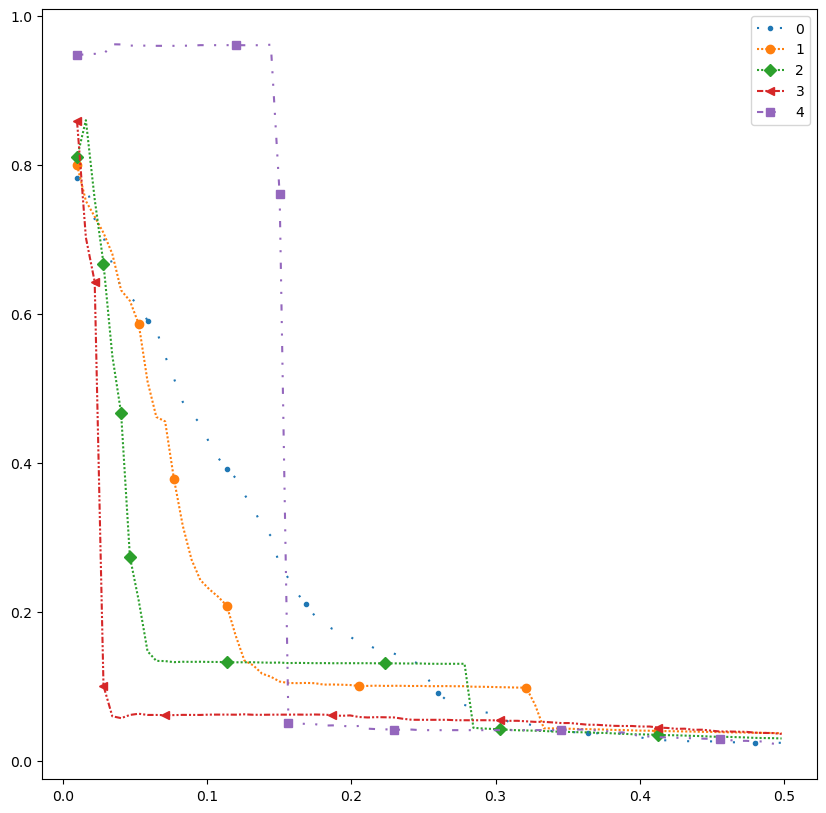

In [122]:
plt.figure(figsize=[10, 10])
pc = prop_cycler()
for ix, label in enumerate(data_per_label):
    plt.plot(
        data_per_label[label]["scan_ratios"], data_per_label[label]["rmses"], label=label, markevery=0.15, **next(pc)
    )
plt.legend(loc="best")
# plt.xlim([0.01, 0.3])
plt.show()

In [123]:
ratios_to_plot = [1, 7, 21, 28, 35, 42, 49]
indices = [np.argmin(np.abs(data_per_label[0]["scan_ratios"] * 100 - r)) for r in ratios_to_plot]

In [124]:
indices

[0, 10, 33, 44, 56, 67, 79]

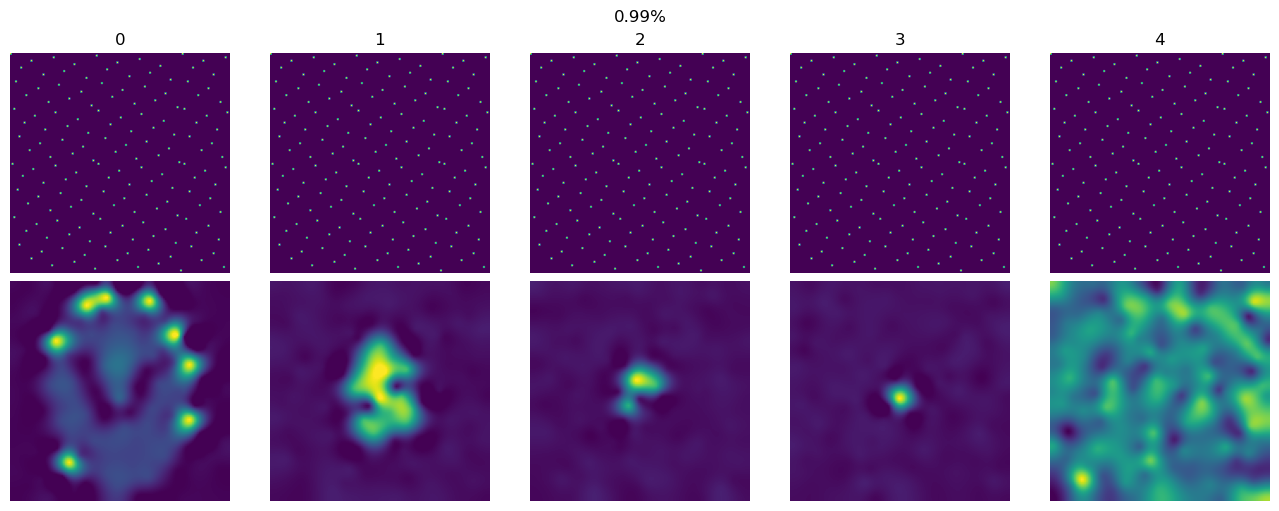

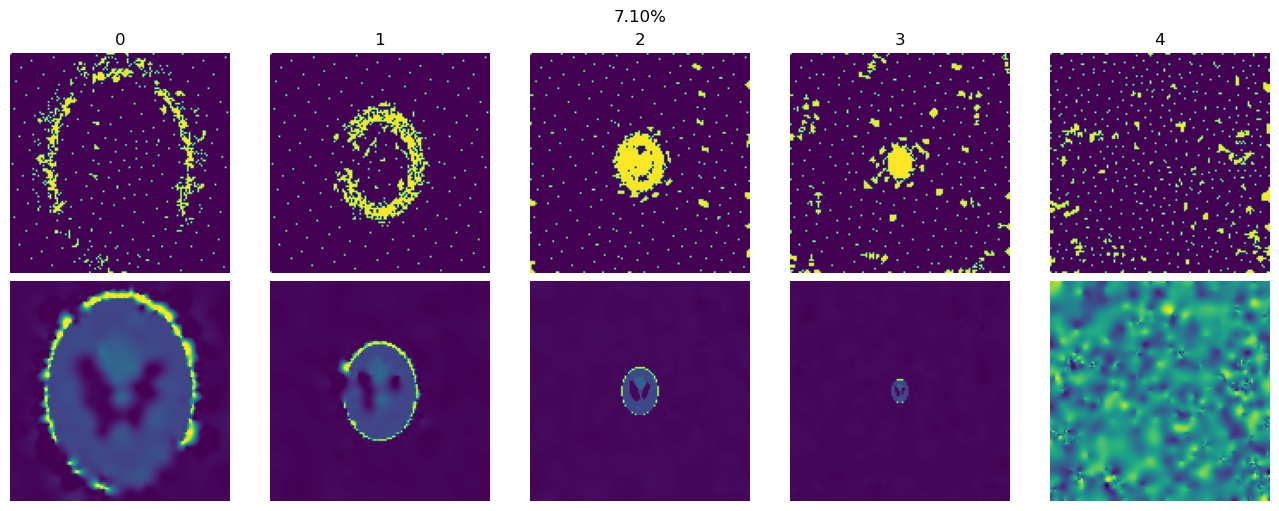

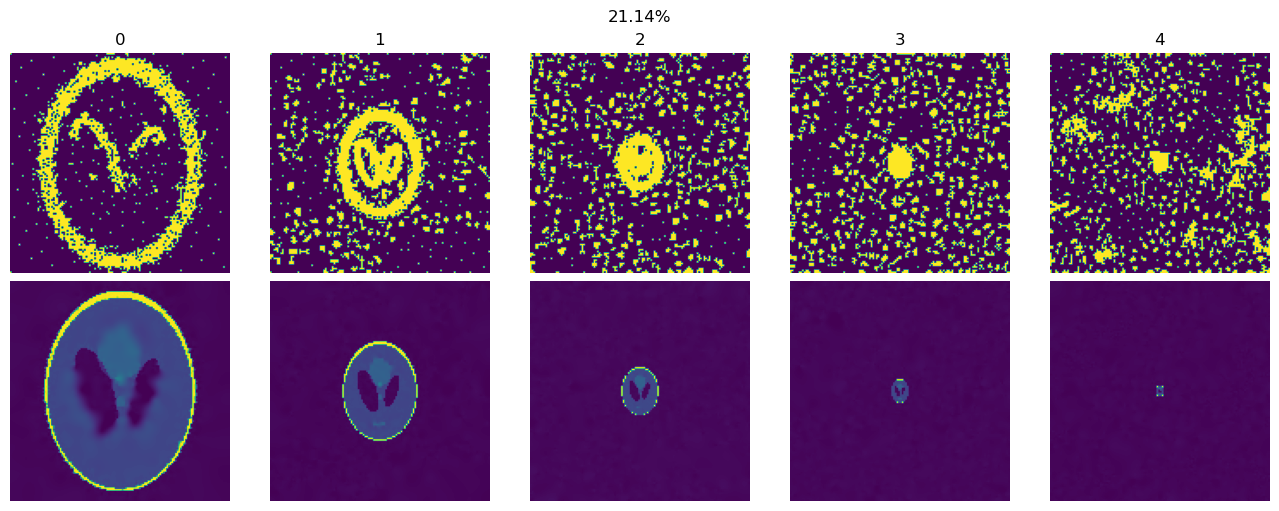

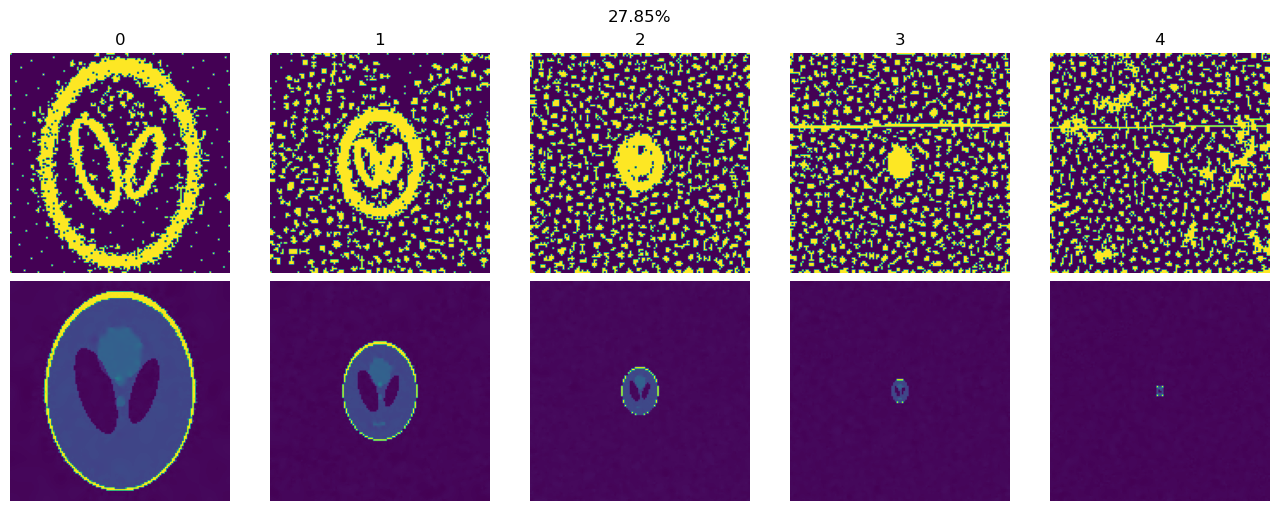

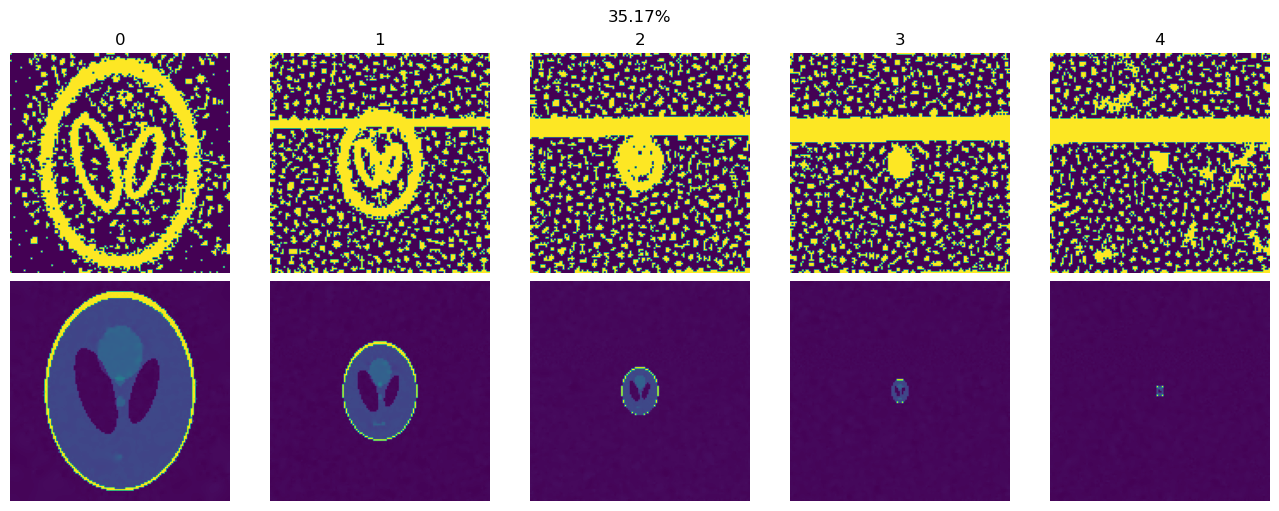

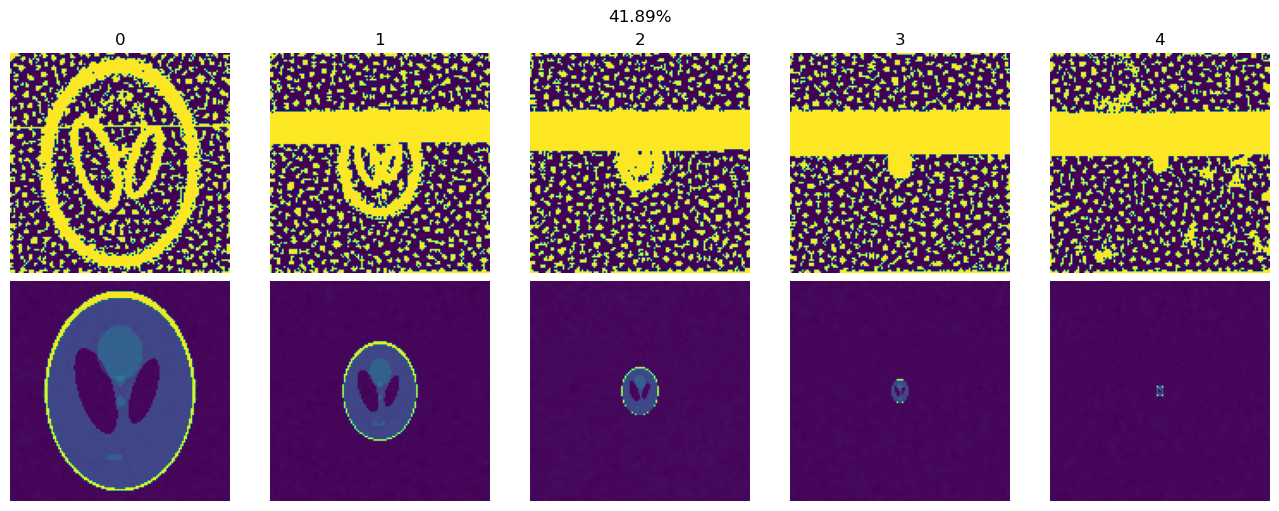

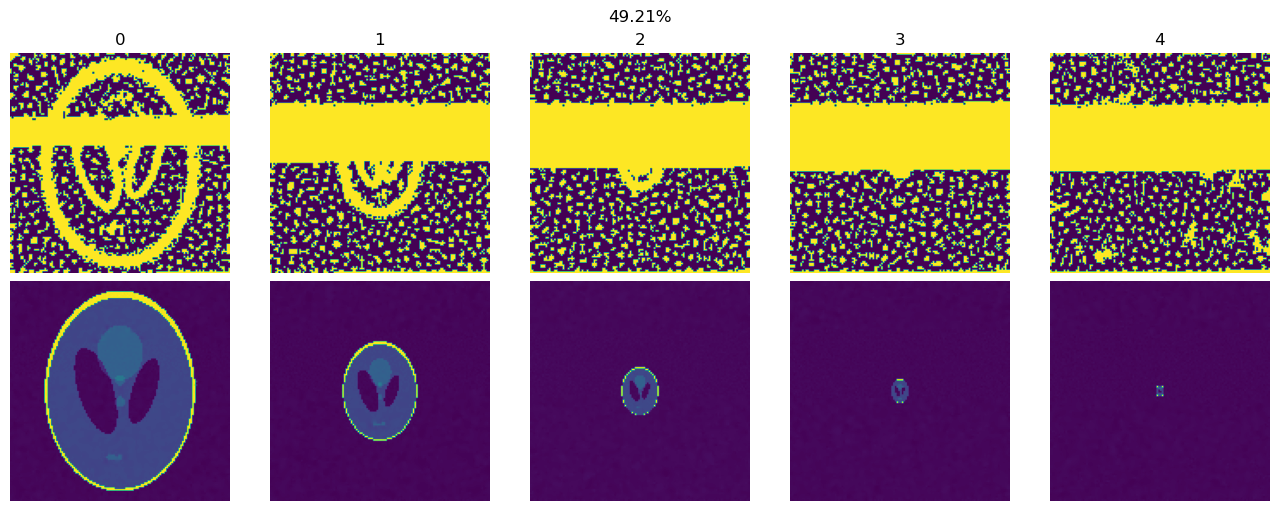

In [125]:
for ix, sr in enumerate(data_per_label[0]["scan_ratios"]):
    if ix not in indices:
        continue
    # if sr > 0.3 or ix==0: continue
    # if ix % 2 != 0: continue
    fig, axs = plt.subplots(2, 5, figsize=[13, 5], constrained_layout=True)

    for iy, label in enumerate(data_per_label):
        axs[0, iy].imshow(data_per_label[label]["masks"][ix])
        axs[0, iy].set_title(label)
        axs[0, iy].axis("off")

        axs[1, iy].imshow(data_per_label[label]["recons_bh"][ix])
        axs[1, iy].axis("off")
    fig.suptitle(f"{sr * 100:4.2f}%")
    # plt.tight_layout()
    plt.show()

In [126]:
rc.shutdown(hub=True)

engine set stopped 1680196395: {'exit_code': 0, 'pid': 1452132, 'identifier': 'ipengine-1680196394-6xs8-1680196395-1326262'}


In [127]:
np.sum(sps_scaled[3] > 5)

94

Controller stopped: {'exit_code': 0, 'pid': 1452040, 'identifier': 'ipcontroller-1680196394-6xs8-1326262'}
